## **Hierachical Clustering**


In [20]:
#Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [21]:
df = pd.read_csv("stock_data.csv")
df.head()

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,AAL,American Airlines Group,Industrials,Airlines,42.349998,9.999995,1.687151,135,51,-604000000,7610000000,11.39,6.681299e+08,3.718174,-8.784219
1,ABBV,AbbVie,Health Care,Pharmaceuticals,59.240002,8.339433,2.197887,130,77,51000000,5144000000,3.15,1.633016e+09,18.806350,-8.750068
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,44.910000,11.301121,1.273646,21,67,938000000,4423000000,2.94,1.504422e+09,15.275510,-0.394171
3,ADBE,Adobe Systems Inc,Information Technology,Application Software,93.940002,13.977195,1.357679,9,180,-240840000,629551000,1.26,4.996437e+08,74.555557,4.199651
4,ADI,"Analog Devices, Inc.",Information Technology,Semiconductors,55.320000,-1.827858,1.701169,14,272,315120000,696878000,0.31,2.247994e+09,178.451613,1.059810


# **Data Preprocessing**

In [22]:
df.shape

(340, 15)

In [23]:

df.dtypes

,0
Ticker Symbol,object
Security,object
GICS Sector,object
GICS Sub Industry,object
Current Price,float64
Price Change,float64
Volatility,float64
ROE,int64
Cash Ratio,int64
Net Cash Flow,int64


In [24]:
#Dropping categorical features
drop_cols = ['Ticker Symbol', 'Security', 'GICS Sector', 'GICS Sub Industry']
df = df.drop(columns=drop_cols)
df.head()

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,42.349998,9.999995,1.687151,135,51,-604000000,7610000000,11.39,6.681299e+08,3.718174,-8.784219
1,59.240002,8.339433,2.197887,130,77,51000000,5144000000,3.15,1.633016e+09,18.806350,-8.750068
2,44.910000,11.301121,1.273646,21,67,938000000,4423000000,2.94,1.504422e+09,15.275510,-0.394171
3,93.940002,13.977195,1.357679,9,180,-240840000,629551000,1.26,4.996437e+08,74.555557,4.199651
4,55.320000,-1.827858,1.701169,14,272,315120000,696878000,0.31,2.247994e+09,178.451613,1.059810


In [25]:
# Converting all columns to numeric data type
df = df.apply(pd.to_numeric, errors='coerce')
df.head()

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,42.349998,9.999995,1.687151,135,51,-604000000,7610000000,11.39,6.681299e+08,3.718174,-8.784219
1,59.240002,8.339433,2.197887,130,77,51000000,5144000000,3.15,1.633016e+09,18.806350,-8.750068
2,44.910000,11.301121,1.273646,21,67,938000000,4423000000,2.94,1.504422e+09,15.275510,-0.394171
3,93.940002,13.977195,1.357679,9,180,-240840000,629551000,1.26,4.996437e+08,74.555557,4.199651
4,55.320000,-1.827858,1.701169,14,272,315120000,696878000,0.31,2.247994e+09,178.451613,1.059810


In [26]:
df.isnull().sum()

,0
Current Price,0
Price Change,0
Volatility,0
ROE,0
Cash Ratio,0
Net Cash Flow,0
Net Income,0
Earnings Per Share,0
Estimated Shares Outstanding,0
P/E Ratio,0


In [27]:
# Standardizing the features (mean=0. variance=1)
X = df.values
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_scaled = (X - X_mean) / X_std

In [28]:
# Hierarchical Clustering class
class HC:
    # Initialize linkage type ('complete' or 'single')
    def __init__(self, linkage_type='complete'):
        self.linkage_type = linkage_type

    # Euclidean distance function between two points
    def euclidean_distance(self, x, y):
        return np.sqrt(np.sum((x - y) ** 2))

    # Find minimum non-diagonal value in distance matrix D and its indices
    def argmin(self, D):
        min_val = float('inf')
        minx, miny = 0, 0
        for i in range(D.shape[0]):
            for j in range(D.shape[1]):
                if i == j:
                    continue
                if D[i, j] < min_val:
                    min_val = D[i, j]
                    minx, miny = i, j
        return min_val, minx, miny
    # Computing distance matrix between clusters
    def cluster_distance(self, cluster_members, X):
        nClusters = len(cluster_members)
        keys = list(cluster_members.keys())
        Distance = np.zeros((nClusters, nClusters))
        for i in range(nClusters):
            for j in range(nClusters):
                if i == j:
                    continue
                ith_elems = cluster_members[keys[i]]
                jth_elems = cluster_members[keys[j]]
                distances = [self.euclidean_distance(X[p1], X[p2])
                            for p1 in ith_elems for p2 in jth_elems]
                if self.linkage_type == 'complete':
                    Distance[i, j] = np.max(distances)
                elif self.linkage_type == 'single':
                    Distance[i, j] = np.min(distances)
        return Distance
    # Fit hierarchical clustering and build linkage matrix Z
    def fit(self, X):
        self.X = X
        self.nSamples = X.shape[0]
        cluster_members = {i: [i] for i in range(self.nSamples)}
        Z = np.zeros((self.nSamples - 1, 4))

        for i in range(self.nSamples - 1):
            D = self.cluster_distance(cluster_members, X)
            dist, tmpx, tmpy = self.argmin(D)
            keys = list(cluster_members.keys())
            x, y = keys[tmpx], keys[tmpy]
            Z[i, 0] = x
            Z[i, 1] = y
            Z[i, 2] = dist
            Z[i, 3] = len(cluster_members[x]) + len(cluster_members[y])
            cluster_members[i + self.nSamples] = cluster_members[x] + cluster_members[y]
            del cluster_members[x]
            del cluster_members[y]

        self.Z = Z
        return self
    # Prediction function
    def predict(self, n_clusters=3):
        # Assign cluster labels for specified number of clusters
        cluster_members = {i: [i] for i in range(self.nSamples)}
        for i in range(self.nSamples - n_clusters):
            x, y = int(self.Z[i, 0]), int(self.Z[i, 1])
            cluster_members[self.nSamples + i] = cluster_members[x] + cluster_members[y]
            del cluster_members[x]
            del cluster_members[y]

        labels = np.zeros(self.nSamples)
        for i, key in enumerate(cluster_members):
            for sample in cluster_members[key]:
                labels[sample] = i
        return labels

In [31]:
#Dendrogram Function fro plot
def plot_dendrogram(Z, nSamples, n_clusters=4):
    # Tracking cluster positions and heights for plotting
    cluster_pos = {i: (i, 0) for i in range(nSamples)}  # (x, y) for each cluster
    lines = []  # Store lines for plotting: (x1, y1, x2, y2)

     # Find the distance threshold for n_clusters
    threshold = 0
    for i in range(Z.shape[0] - n_clusters + 1):
        threshold = max(threshold, Z[i, 2])


    for i in range(Z.shape[0]):
        c1, c2, dist, _ = Z[i]
        c1, c2 = int(c1), int(c2)
        x1, y1 = cluster_pos[c1]
        x2, y2 = cluster_pos[c2]
        # New cluster position at average x and height = distance
        new_x = (x1 + x2) / 2
        new_y = dist
        # Adding lines: vertical to merge point, horizontal to connect clusters
        lines.append((x1, y1, x1, new_y))  # Vertical line for c1
        lines.append((x2, y2, x2, new_y))  # Vertical line for c2
        lines.append((x1, new_y, x2, new_y))  # Horizontal line
        # Update cluster position
        cluster_pos[nSamples + i] = (new_x, new_y)

   # Plotting the dendrogram
    plt.figure(figsize=(12, 6))
    cmap = plt.get_cmap('viridis')
    max_dist = np.max(Z[:, 2]) or 1
    for x1, y1, x2, y2 in lines:
        color = cmap(y2 / max_dist)
        plt.plot([x1, x2], [y1, y2], color=color, linestyle='-')

    # Add horizontal partition line for n_clusters
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Cut for {n_clusters} clusters')
    plt.legend()

    plt.title("Dendrogram of Stock Data")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.xticks(np.arange(nSamples), np.arange(nSamples), rotation=90)
    plt.show()

In [18]:
# Calling the hierarchical clustering
hc = HC(linkage_type='complete')
hc.fit(X_scaled)

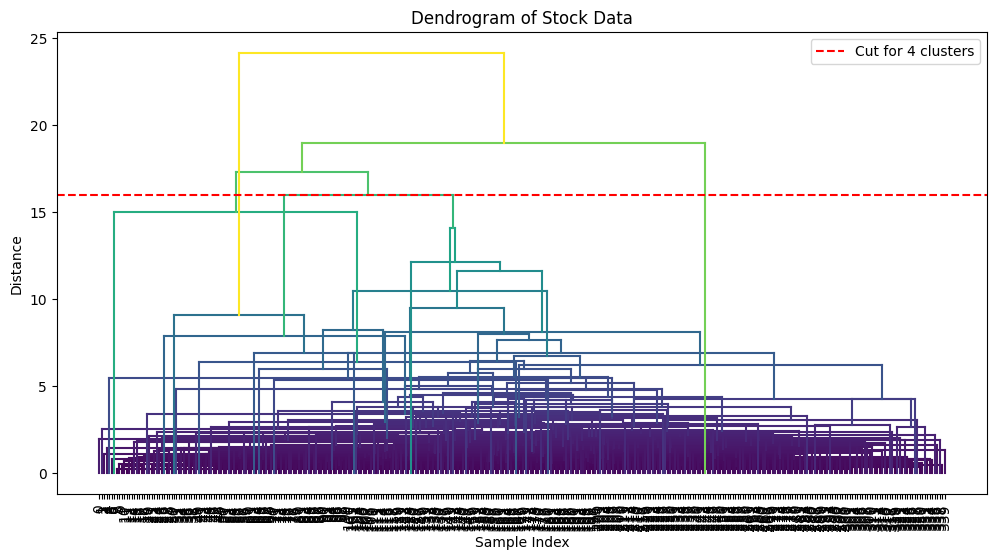

In [32]:
# Calling the plot fucntion for dendrogram
plot_dendrogram(hc.Z, hc.nSamples, n_clusters=4)

Observation:

1. Partition Line: The red dashed line at a distance ~15 indicates the cut for 4 clusters, it cuts the major branches hence forming 4 clusters.

2. Outliers: A few stocks merge above 20 (yellow lines), indicating potential outliers with distinct financial profiles

In [33]:
# Predicting clusters (e.g., 5 clusters for diversity)
n_clusters = 5
labels = hc.predict(n_clusters)

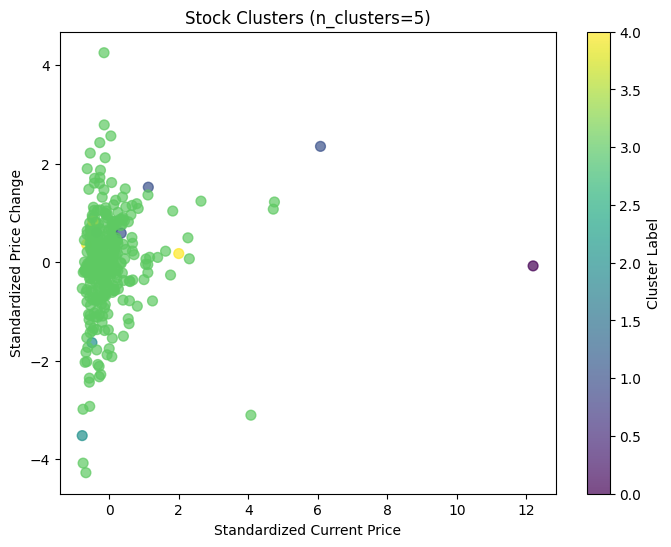

In [34]:
# Plottting clusters (using first two features)
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Cluster Label')
plt.title(f"Stock Clusters (n_clusters={n_clusters})")
plt.xlabel("Standardized Current Price")
plt.ylabel("Standardized Price Change")
plt.show()